In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

# **DATA**

In [12]:
new_market = pd.read_csv('./new_market.csv')
new_market['pricingDate'] = pd.to_datetime(new_market['pricingDate'])
# 2018.05.01 ~ 2023.04.30 기간 데이터 필터링
filtered_data = new_market[(new_market['pricingDate'] >= '2018-05-01') & (new_market['pricingDate'] <= '2023-04-30')]

In [13]:
ticker_15 = ['AAPL', 'AMZN', 'NVDA', 'JPM', 'PG', 'PFE', 'JNJ', 'KO', 'XOM', 'NEE',
             'GOOGL', 'MSFT', 'TSLA', 'NKE', 'BAC']

ticker_30 = ['MSFT', 'AMZN', 'NVDA', 'AAPL', 'GOOGL', 'ADBE', 'JNJ', 'PFE', 'MRK', 
             'ABT', 'PG', 'KO', 'JPM', 'GS', 'CAT', 'CVX', 'XOM', 'BA', 'TSLA', 'NEE', 
             'NKE', 'VZ', 'CRM', 'UNH', 'WMT', 'QCOM', 'BAC', 'V', 'MCD', 'INTC']

ticker_45 = ['AAPL', 'GOOGL', 'MSFT', 'NVDA', 'AMD', 'ORCL', 'CRM', 'INTC', 'CSCO', 
             'JPM', 'GS', 'BAC', 'MS', 'AXP', 'C', 'JNJ', 'UNH', 'PFE', 'ABBV', 'TSLA', 
             'AMGN', 'GILD', 'PG', 'KO', 'NKE', 'PEP', 'COST', 'WMT', 'TGT', 'XOM', 
             'CVX', 'NEE', 'DUK', 'SO', 'SLB', 'MMM', 'CAT', 'HON', 'GE', 'ADP', 'AMZN', 
             'META', 'HD', 'VZ', 'MRK']

a = ['pricingDate'] + ticker_15
b = ['pricingDate'] + ticker_30
c = ['pricingDate'] + ticker_45
 
ticker_15_price = filtered_data[a]
ticker_30_price = filtered_data[b]
ticker_45_price = filtered_data[c]

# **Scenario**

In [14]:
# 2018.05.01 ~ 2023.04.30 기간에서 30일씩 3번에 걸쳐서 랜덤하게 선택되는 시나리오를 1000개 만들기

# 각 시나리오 부분별로 필요한 일수
days_per_part = 30

num_scenarios = 1000
total_days = ticker_15_price.shape[0]

scenarios = []

# 각 시나리오를 3개의 랜덤한 30일로 구성

for _ in range(num_scenarios):
   
    scenario_data = pd.DataFrame()

    # 사용된 일자를 추적하기 위한 집합
    used_days = set()

    for _ in range(3):
        # 중복되지 않는 30일 기간을 선택
        while True:
            start_day = np.random.randint(0, total_days - days_per_part)
            end_day = start_day + days_per_part

            # 선택된 기간이 이전에 사용된 일자와 중복되지 않는지 확인
            if not used_days.intersection(set(range(start_day, end_day))):
                break

        # 사용된 일자 업데이트
        used_days.update(range(start_day, end_day))

        # 데이터셋에서 30일 기간의 데이터 추출
        part_data = ticker_15_price.iloc[start_day:end_day]

        # 추출된 30일 데이터를 시나리오 데이터에 추가
        scenario_data = pd.concat([scenario_data, part_data])

    # 완성된 시나리오 데이터를 시나리오 목록에 추가
    scenarios.append(scenario_data)


scenarios[0]

,pricingDate,AAPL,AMZN,NVDA,JPM,PG,PFE,JNJ,KO,XOM,NEE,GOOGL,MSFT,TSLA,NKE,BAC
851,2021-09-16,147.088312,174.4120,222.105982,147.925496,137.152739,41.393930,156.475141,52.126051,51.697509,80.284123,143.6100,299.788945,252.330000,154.176139,38.456818
852,2021-09-17,144.389535,173.1260,218.690810,147.541858,137.371636,40.854050,156.030017,51.269055,51.086252,78.028521,140.8000,294.534143,253.163333,153.021775,38.504354
853,2021-09-20,141.305218,167.7865,210.831921,143.125333,135.991638,41.142607,155.139770,50.911189,49.724816,78.076309,138.7195,289.063255,243.390000,150.898918,37.182846
854,2021-09-21,141.789614,167.1815,212.160044,143.144047,136.201017,40.881975,155.821661,50.901772,49.678509,78.296135,139.0330,289.554358,246.460000,151.652190,37.201861
855,2021-09-22,144.181936,169.0025,219.100232,145.885661,136.667361,40.909900,155.253419,50.977112,51.132559,78.277020,140.2835,293.267097,250.646666,154.019615,38.162093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2019-04-16,48.078886,93.1520,46.739247,96.977227,95.107819,32.732231,122.320587,40.837714,64.154330,42.958709,61.5955,115.406453,18.224000,83.927315,26.803264
242,2019-04-17,49.015128,93.2410,46.510778,99.770450,95.266131,31.900327,122.763714,41.124753,64.336048,42.988177,62.0070,116.362042,18.082000,84.816294,26.937819
243,2019-04-18,49.191276,93.0845,46.264926,99.037229,95.446133,31.500373,121.877461,41.298715,64.099024,42.922442,62.0735,117.890984,18.217333,85.265564,26.937819
244,2019-04-22,49.352947,94.3655,46.803814,99.159432,95.410132,31.180410,122.152199,41.229130,65.497462,43.153646,62.6880,118.263663,17.516666,83.506722,26.955760


In [15]:
# 시나리오가 랜덤하게 잘 구성되었는지 확인

scenario0 = scenarios[0]
scenario1 = scenarios[1]
scenario2 = scenarios[2]
scenario3 = scenarios[3]

In [16]:
#시나리오 주간 기대수익률, 표준편차 계산

# 각 시나리오에 대해 가중치가 적용된 수익률을 계산하는 함수
def calculate_weighted_returns(scenario, weights):
   
    # 날짜(비수치데이터) 제거
    scenario_numeric = scenario.select_dtypes(include=[np.number])

    # 가중치가 적용된 수익률 계산
    weighted_returns = scenario_numeric.multiply(weights) 
    total_returns = weighted_returns.sum(axis=1)
    return total_returns

#각 시나리오에 대한 일간 수익률 통계를 계산하는 함수
def calculate_daily_statistics(scenarios, weights):
    daily_stats = []

    for scenario in scenarios:
        # 총 가중치가 적용된 수익률 계산
        total_returns = calculate_weighted_returns(scenario, weights)

        # 일별 수익률 계산
        daily_returns = total_returns.pct_change().dropna()  # pct_change() 함수는 기본적으로 1일 간격으로 수익률을 계산

        # 통계 계산
        mean_return = daily_returns.mean()
        std_deviation = daily_returns.std()

        daily_stats.append((mean_return, std_deviation))

    return daily_stats

# **GPT-weighted Portfolio simulation**

In [17]:
gpt_weighted_15 = {
    "AAPL": 0.084, "AMZN": 0.074, "NVDA": 0.064, "JPM": 0.054, "PG": 0.054,
    "PFE": 0.064, "JNJ": 0.064, "KO": 0.054, "XOM": 0.064, "NEE": 0.074,
    "GOOGL": 0.084, "MSFT": 0.084, "TSLA": 0.074, "NKE": 0.054, "BAC": 0.054
}

gpt_weighted_30 = {
    "MSFT": 0.067, "AMZN": 0.067, "NVDA": 0.067, "AAPL": 0.067, "GOOGL": 0.067,
    "ADBE": 0.067, "JNJ": 0.05, "PFE": 0.05, "MRK": 0.05, "ABT": 0.05, 
    "PG": 0.05, "KO": 0.05, "JPM": 0.05, "GS": 0.05, "CAT": 0.025, 
    "CVX": 0.025, "XOM": 0.025, "BA": 0.025, "TSLA": 0.025, "NEE": 0.025, 
    "NKE": 0.005, "VZ": 0.005, "CRM": 0.005, "UNH": 0.005, "WMT": 0.005, 
    "QCOM": 0.005, "BAC": 0.005, "V": 0.005, "MCD": 0.005, "INTC": 0.005
}

gpt_weighted_45 = {
    "AAPL": 0.05, "GOOGL": 0.04, "MSFT": 0.04, "NVDA": 0.03, "AMD": 0.03, 
    "ORCL": 0.02, "CRM": 0.02, "INTC": 0.01, "CSCO": 0.01, "JPM": 0.04, 
    "GS": 0.03, "BAC": 0.03, "MS": 0.02, "AXP": 0.02, "C": 0.01,
    "JNJ": 0.03, "UNH": 0.03, "PFE": 0.02, "ABBV": 0.02, "TSLA": 0.02, 
    "AMGN": 0.02, "GILD": 0.01, "PG": 0.03, "KO": 0.03, "NKE": 0.02, 
    "PEP": 0.02, "COST": 0.02, "WMT": 0.02, "TGT": 0.01, "XOM": 0.025, 
    "CVX": 0.025, "NEE": 0.02, "DUK": 0.01, "SO": 0.01, "SLB": 0.01,
    "MMM": 0.02, "CAT": 0.02, "HON": 0.02, "GE": 0.02, "ADP": 0.02,
    "AMZN": 0.02, "META": 0.02, "HD": 0.02, "VZ": 0.01, "MRK": 0.01
}

In [18]:
# 시나리오 분석 수행 각각의 가중치 시리즈만 넣어서 만들면 됨
weights_series_gpt_15 = pd.Series(gpt_weighted_15) 
daily_statistics_gpt_15 = calculate_daily_statistics(scenarios, weights_series_gpt_15) 

weights_series_gpt_30 = pd.Series(gpt_weighted_30)
daily_statistics_gpt_30 = calculate_daily_statistics(scenarios, weights_series_gpt_30)

weights_series_gpt_45 = pd.Series(gpt_weighted_45)
daily_statistics_gpt_45 = calculate_daily_statistics(scenarios, weights_series_gpt_45)

# 첫 번째 시나리오의 통계를 예시로 표시
daily_statistics_gpt_15[0]

(-0.006590125947382237, 0.05507948399800754)

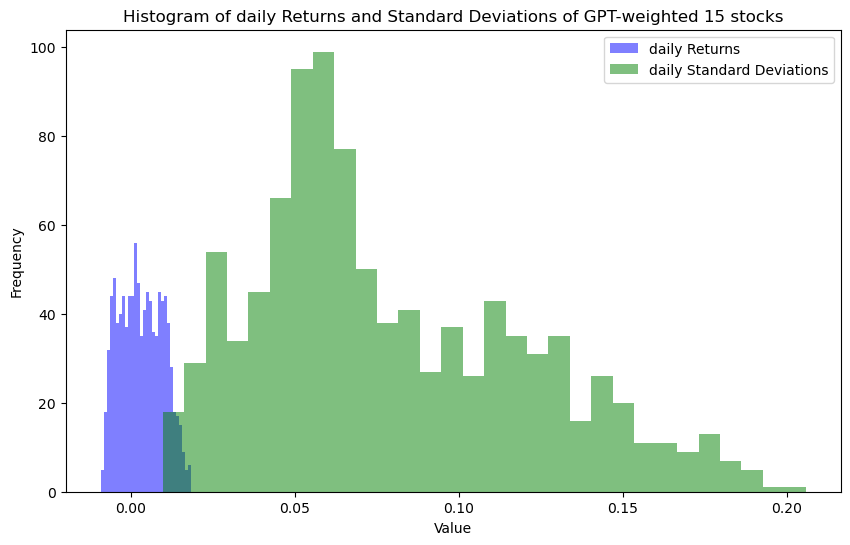

In [19]:
# GPT-weighted 15 stocks의 주간 수익률과 표준편차 히스토그램

# 누적수익률도 그리기 (3개월동안 전체 수익률)

returns_15, std_devs_15 = zip(*daily_statistics_gpt_15)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_15, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_15, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of GPT-weighted 15 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

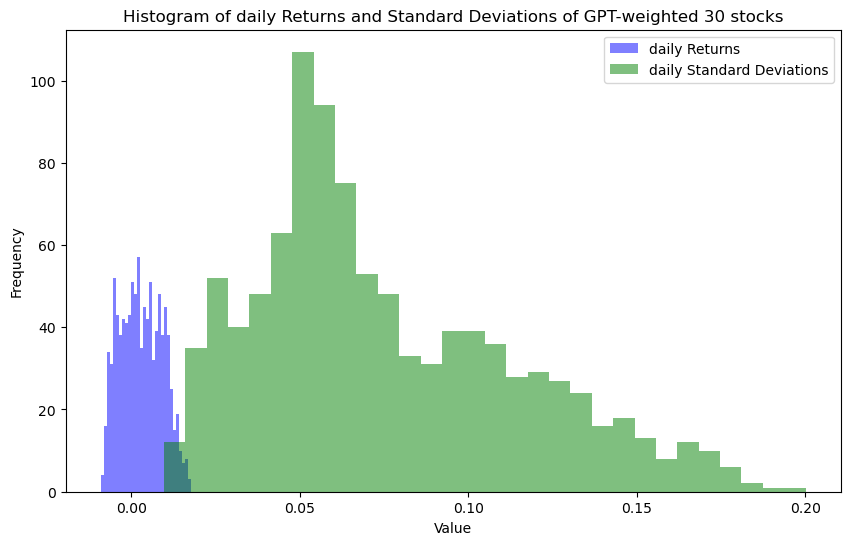

In [20]:
#GPT-weighted 30 stocks의 주간 수익률과 표준편차 히스토그램

returns_30, std_devs_30 = zip(*daily_statistics_gpt_30)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_30, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_30, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of GPT-weighted 30 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

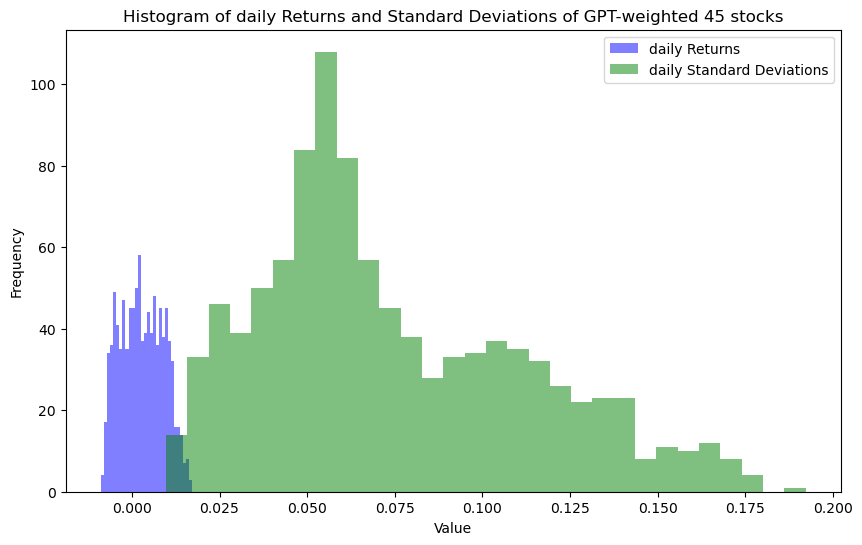

In [21]:
#GPT-weighted 45 stocks의 주간 수익률과 표준편차 히스토그램

returns_45, std_devs_45 = zip(*daily_statistics_gpt_45)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_45, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_45, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of GPT-weighted 45 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

# **GPT-Equal Portfolio simulation**

In [22]:
gpt_equal_15 = {
    "AAPL": 0.06666666666666667,
    "AMZN": 0.06666666666666667,
    "NVDA": 0.06666666666666667,
    "JPM": 0.06666666666666667,
    "PG": 0.06666666666666667,
    "PFE": 0.06666666666666667,
    "JNJ": 0.06666666666666667,
    "KO": 0.06666666666666667,
    "XOM": 0.06666666666666667,
    "NEE": 0.06666666666666667,
    "GOOGL": 0.06666666666666667,
    "MSFT": 0.06666666666666667,
    "TSLA": 0.06666666666666667,
    "NKE": 0.06666666666666667,
    "BAC": 0.06666666666666667
}

gpt_equal_30 = {
    "MSFT": 0.03333333333333333,
    "AMZN": 0.03333333333333333,
    "NVDA": 0.03333333333333333,
    "AAPL": 0.03333333333333333,
    "GOOGL": 0.03333333333333333,
    "ADBE": 0.03333333333333333,
    "JNJ": 0.03333333333333333,
    "PFE": 0.03333333333333333,
    "MRK": 0.03333333333333333,
    "ABT": 0.03333333333333333,
    "PG": 0.03333333333333333,
    "KO": 0.03333333333333333,
    "JPM": 0.03333333333333333,
    "GS": 0.03333333333333333,
    "CAT": 0.03333333333333333,
    "CVX": 0.03333333333333333,
    "XOM": 0.03333333333333333,
    "BA": 0.03333333333333333,
    "TSLA": 0.03333333333333333,
    "NEE": 0.03333333333333333,
    "NKE": 0.03333333333333333,
    "VZ": 0.03333333333333333,
    "CRM": 0.03333333333333333,
    "UNH": 0.03333333333333333,
    "WMT": 0.03333333333333333,
    "QCOM": 0.03333333333333333,
    "BAC": 0.03333333333333333,
    "V": 0.03333333333333333,
    "MCD": 0.03333333333333333,
    "INTC": 0.03333333333333333
}

gpt_equal_45 = {
    "AAPL": 0.022222,
    "GOOGL": 0.022222,
    "MSFT": 0.022222,
    "NVDA": 0.022222,
    "AMD": 0.022222,
    "ORCL": 0.022222,
    "CRM": 0.022222,
    "INTC": 0.022222,
    "CSCO": 0.022222,
    "JPM": 0.022222,
    "GS": 0.022222,
    "BAC": 0.022222,
    "MS": 0.022222,
    "AXP": 0.022222,
    "C": 0.022222,
    "JNJ": 0.022222,
    "UNH": 0.022222,
    "PFE": 0.022222,
    "ABBV": 0.022222,
    "TSLA": 0.022222,
    "AMGN": 0.022222,
    "GILD": 0.022222,
    "PG": 0.022222,
    "KO": 0.022222,
    "NKE": 0.022222,
    "PEP": 0.022222,
    "COST": 0.022222,
    "WMT": 0.022222,
    "TGT": 0.022222,
    "XOM": 0.022222,
    "CVX": 0.022222,
    "NEE": 0.022222,
    "DUK": 0.022222,
    "SO": 0.022222,
    "SLB": 0.022222,
    "MMM": 0.022222,
    "CAT": 0.022222,
    "HON": 0.022222,
    "GE": 0.022222,
    "ADP": 0.022222,
    "AMZN": 0.022222,
    "META": 0.022222,
    "HD": 0.022222,
    "VZ": 0.022222,
    "MRK": 0.022222,

}

In [23]:
# 시나리오 분석 수행 각각의 가중치 시리즈만 넣어서 만들면 됨
weights_series_gpt_equal_15 = pd.Series(gpt_equal_15) 
daily_statistics_gpt_equal_15 = calculate_daily_statistics(scenarios, weights_series_gpt_equal_15) 

weights_series_gpt_equal_30 = pd.Series(gpt_equal_30)
daily_statistics_gpt_equal_30 = calculate_daily_statistics(scenarios, weights_series_gpt_equal_30)

weights_series_gpt_equal_45 = pd.Series(gpt_equal_45)
daily_statistics_gpt_equal_45 = calculate_daily_statistics(scenarios, weights_series_gpt_equal_45)

# 첫 번째 시나리오의 통계를 예시로 표시
daily_statistics_gpt_equal_15[0]

(-0.006338650058014583, 0.0529886975191145)

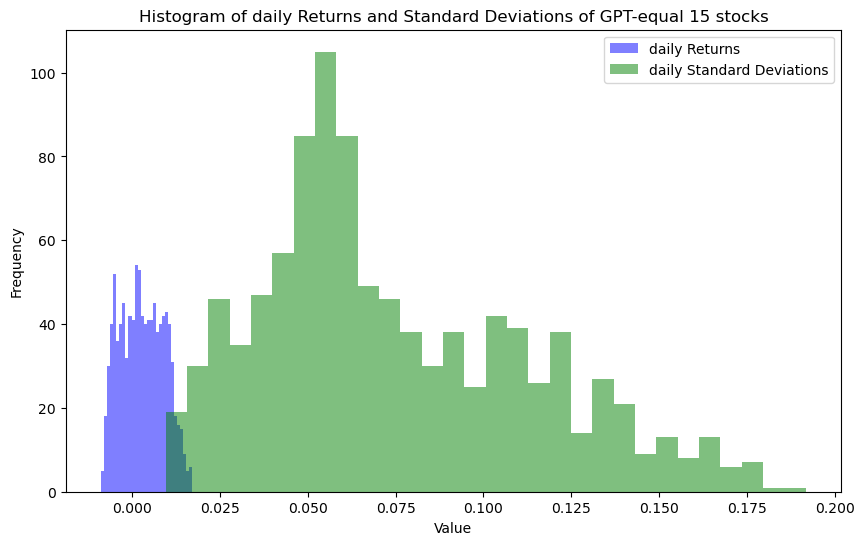

In [24]:
#GPT-equal 15 stocks의 주간 수익률과 표준편차 히스토그램

returns_equal_15, std_devs_equal_15 = zip(*daily_statistics_gpt_equal_15)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_equal_15, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_equal_15, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of GPT-equal 15 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

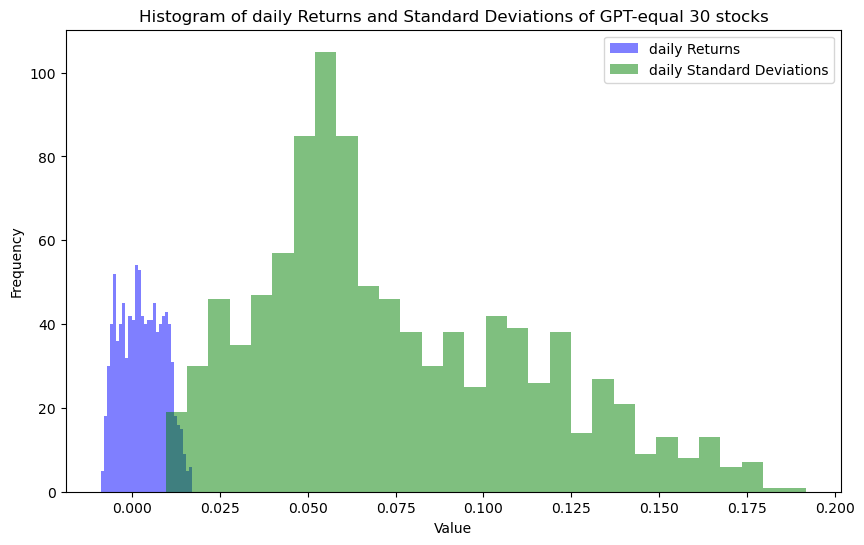

In [25]:
#GPT-equal 30 stocks의 주간 수익률과 표준편차 히스토그램

returns_equal_30, std_devs_equal_30 = zip(*daily_statistics_gpt_equal_30)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_equal_30, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_equal_30, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of GPT-equal 30 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

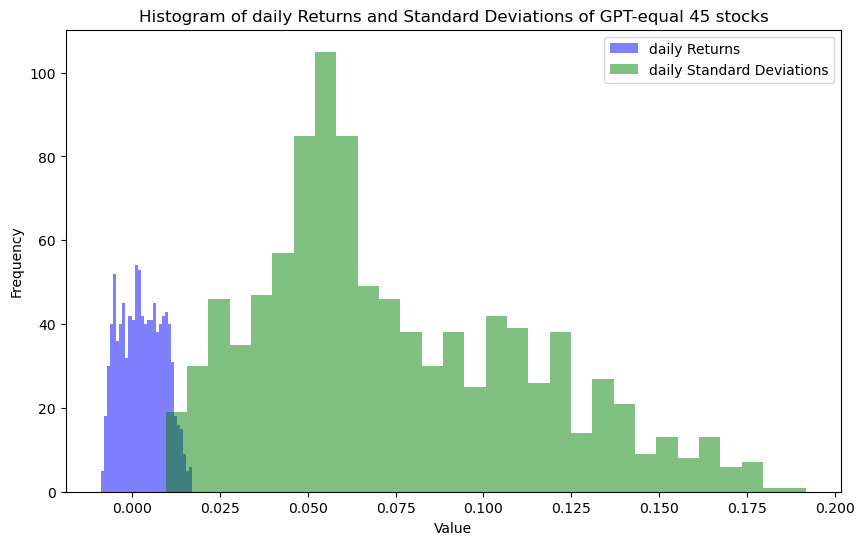

In [26]:
#GPT-equal 45 stocks의 주간 수익률과 표준편차 히스토그램

returns_equal_45, std_devs_equal_45 = zip(*daily_statistics_gpt_equal_45)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_equal_45, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_equal_45, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of GPT-equal 45 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

# **Mean-Variance Optimization**

## GMV

In [27]:
MVO_GMV_weighted_15 = {'AAPL': 0.03333374405100818,
 'AMZN': 0.033334588116497435,
 'NVDA': 0.03333348978722604,
 'JPM': 0.03333398514503214,
 'PG': 0.1333327361134369,
 'PFE': 0.13333243975930342,
 'JNJ': 0.1333328801282149,
 'KO': 0.13333263630232933,
 'XOM': 0.06275993684703628,
 'NEE': 0.10390437355944876,
 'GOOGL': 0.033334014760777,
 'MSFT': 0.03333378694216374,
 'TSLA': 0.033333526201165434,
 'NKE': 0.03333412746870001,
 'BAC': 0.03333373481766047}

MVO_GMV_weighted_30 = {'MSFT': 0.016666721079821905,
 'AMZN': 0.016667167540343083,
 'NVDA': 0.016666684870667,
 'AAPL': 0.016666718865478672,
 'GOOGL': 0.016666761861858326,
 'ADBE': 0.016666712765385196,
 'JNJ': 0.06666662398032082,
 'PFE': 0.06666660776982793,
 'MRK': 0.06666662164123628,
 'ABT': 0.04919809474758443,
 'PG': 0.0666666152279637,
 'KO': 0.06666660761263403,
 'JPM': 0.01666673750868713,
 'GS': 0.016666730499348244,
 'CAT': 0.016666892718601656,
 'CVX': 0.01666675225225722,
 'XOM': 0.034133822269706314,
 'BA': 0.016666688590042056,
 'TSLA': 0.016666694041226473,
 'NEE': 0.06666643755151765,
 'NKE': 0.016666773473371085,
 'VZ': 0.06666663719805763,
 'CRM': 0.016666720018305783,
 'UNH': 0.016667066546555444,
 'WMT': 0.0666666332890372,
 'QCOM': 0.016666711438264183,
 'BAC': 0.016666710161146746,
 'V': 0.016666754085972495,
 'MCD': 0.06666658915468787,
 'INTC': 0.016666711240093342}

MVO_GMV_weighted_45 = {'AAPL': 0.011111213758484832,
 'GOOGL': 0.011111343139537204,
 'MSFT': 0.011111225007998026,
 'NVDA': 0.011111151895228117,
 'AMD': 0.011111160772805313,
 'ORCL': 0.011111789666104675,
 'CRM': 0.011111258185929706,
 'INTC': 0.011111188612380408,
 'CSCO': 0.011111295111126287,
 'JPM': 0.011111212354378333,
 'GS': 0.011111213900885054,
 'BAC': 0.011111179143718793,
 'MS': 0.011111171460422687,
 'AXP': 0.011111170532236104,
 'C': 0.011111166775135326,
 'JNJ': 0.0444443229533583,
 'UNH': 0.011111343807737298,
 'PFE': 0.044444235769390834,
 'ABBV': 0.04444425401586451,
 'TSLA': 0.01111119959037893,
 'AMGN': 0.04444407219243035,
 'GILD': 0.04444432447488217,
 'PG': 0.044444278430442845,
 'KO': 0.04444424860370577,
 'NKE': 0.011111324038704228,
 'PEP': 0.04444392106298936,
 'COST': 0.044444242194327,
 'WMT': 0.04444436321847532,
 'TGT': 0.011502437642341646,
 'XOM': 0.011112185823843096,
 'CVX': 0.011111259407763073,
 'NEE': 0.03297992360112413,
 'DUK': 0.0444439534473583,
 'SO': 0.03762800075314799,
 'SLB': 0.011111202014250332,
 'MMM': 0.028995772282074096,
 'CAT': 0.011111308257626953,
 'HON': 0.011111321166848714,
 'GE': 0.011111200584380029,
 'ADP': 0.011111228287854507,
 'AMZN': 0.011114044267634786,
 'META': 0.011111276530642117,
 'HD': 0.011111315549497543,
 'VZ': 0.04444437210764989,
 'MRK': 0.044444327606905115}

In [28]:
# 시나리오 분석 수행 각각의 가중치 시리즈만 넣어서 만들면 됨
weights_series_MVO_GMV_weighted_15 = pd.Series(MVO_GMV_weighted_15)
daily_statistics_MVO_GMV_weighted_15 = calculate_daily_statistics(scenarios, weights_series_MVO_GMV_weighted_15)

weights_series_MVO_GMV_weighted_30 = pd.Series(MVO_GMV_weighted_30)
daily_statistics_MVO_GMV_weighted_30 = calculate_daily_statistics(scenarios, weights_series_MVO_GMV_weighted_30)

weights_series_MVO_GMV_weighted_45 = pd.Series(MVO_GMV_weighted_45)
daily_statistics_MVO_GMV_weighted_45 = calculate_daily_statistics(scenarios, weights_series_MVO_GMV_weighted_45)

# 첫 번째 시나리오의 통계를 예시로 표시
daily_statistics_MVO_GMV_weighted_15[0]

(-0.005090208704844856, 0.039644970965070525)

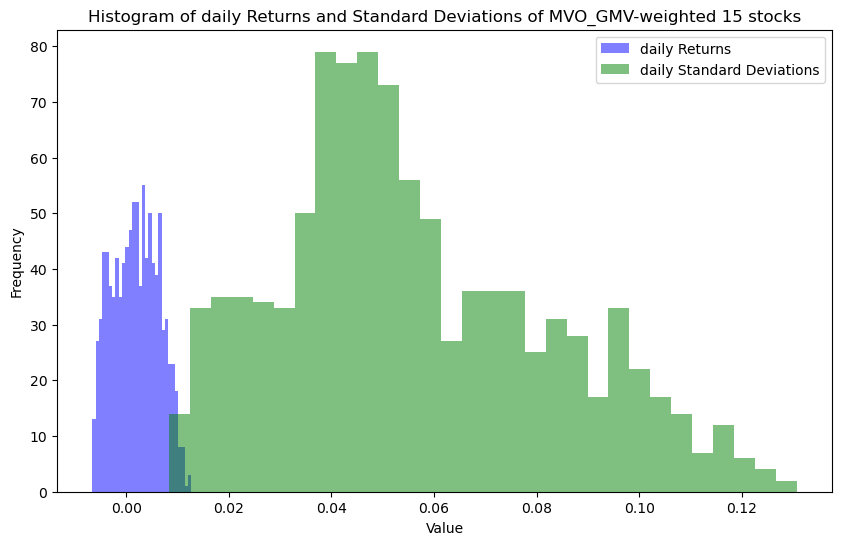

In [29]:
#MVO_GMV_weighted 15의 주간 수익률과 표준편차 히스토그램

returns_MVO_GMV_weighted_15, std_devs_MVO_GMV_weighted_15 = zip(*daily_statistics_MVO_GMV_weighted_15)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_MVO_GMV_weighted_15, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_MVO_GMV_weighted_15, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of MVO_GMV-weighted 15 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

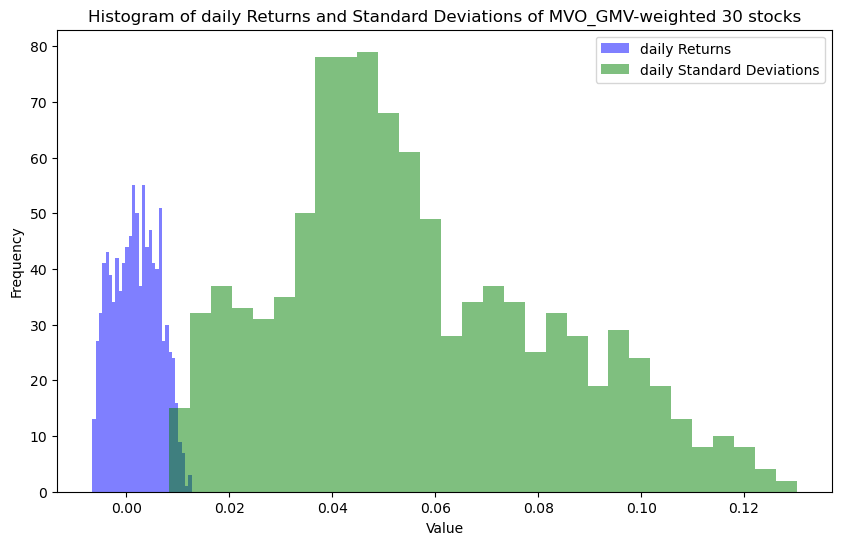

In [30]:
#MVO_GMV_weighted 30의 주간 수익률과 표준편차 히스토그램

returns_MVO_GMV_weighted_30, std_devs_MVO_GMV_weighted_30 = zip(*daily_statistics_MVO_GMV_weighted_30)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_MVO_GMV_weighted_30, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_MVO_GMV_weighted_30, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of MVO_GMV-weighted 30 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

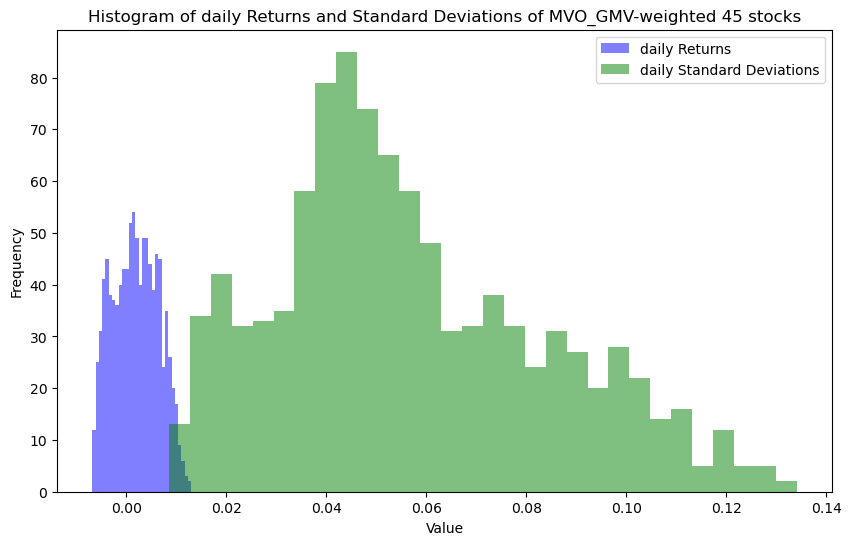

In [31]:
#MVO_GMV_weighted 45의 주간 수익률과 표준편차 히스토그램

returns_MVO_GMV_weighted_45, std_devs_MVO_GMV_weighted_45 = zip(*daily_statistics_MVO_GMV_weighted_45)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_MVO_GMV_weighted_45, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_MVO_GMV_weighted_45, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of MVO_GMV-weighted 45 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

## Max Return

In [32]:
MVO_Maxret_weighted_15 = {'AAPL': 0.13333, 'AMZN': 0.03333, 'NVDA': 0.13333, 'JPM': 0.03333, 'PG': 0.13333, 'PFE': 0.03333, 'JNJ': 0.03333, 'KO': 0.03333, 'XOM': 0.03333, 'NEE': 0.03333, 'GOOGL': 0.03333, 'MSFT': 0.13333, 'TSLA': 0.13333, 'NKE': 0.03333, 'BAC': 0.03333}

MVO_Maxret_weighted_30 = {'MSFT': 0.06667, 'AMZN': 0.01667, 'NVDA': 0.06667, 'AAPL': 0.06667, 'GOOGL': 0.06667, 'ADBE': 0.01667, 'JNJ': 0.01667, 'PFE': 0.01667, 'MRK': 0.06667, 'ABT': 0.01667, 'PG': 0.06667, 'KO': 0.01667, 'JPM': 0.01667, 'GS': 0.01667, 'CAT': 0.01667, 'CVX': 0.01667, 'XOM': 0.01667, 'BA': 0.01667, 'TSLA': 0.06667, 'NEE': 0.06667, 'NKE': 0.01667, 'VZ': 0.01667, 'CRM': 0.01667, 'UNH': 0.06667, 'WMT': 0.01667, 'QCOM': 0.06667, 'BAC': 0.01667, 'V': 0.01667, 'MCD': 0.01667, 'INTC': 0.01667}

MVO_Maxret_weighted_45 = {'AAPL': 0.04444, 'GOOGL': 0.01111, 'MSFT': 0.04444, 'NVDA': 0.04444, 'AMD': 0.04444, 'ORCL': 0.04444, 'CRM': 0.01111, 'INTC': 0.01111, 'CSCO': 0.01111, 'JPM': 0.01111, 'GS': 0.01111, 'BAC': 0.01111, 'MS': 0.01111, 'AXP': 0.01111, 'C': 0.01111, 'JNJ': 0.01111, 'UNH': 0.04444, 'PFE': 0.01111, 'ABBV': 0.01111, 'TSLA': 0.04444, 'AMGN': 0.01111, 'GILD': 0.01111, 'PG': 0.04444, 'KO': 0.01111, 'NKE': 0.01111, 'PEP': 0.04444, 'COST': 0.04444, 'WMT': 0.01111, 'TGT': 0.04444, 'XOM': 0.01111, 'CVX': 0.01111, 'NEE': 0.04444, 'DUK': 0.01111, 'SO': 0.01111, 'SLB': 0.01111, 'MMM': 0.01111, 'CAT': 0.01111, 'HON': 0.01111, 'GE': 0.01111, 'ADP': 0.04444, 'AMZN': 0.01111, 'META': 0.01111, 'HD': 0.01111, 'VZ': 0.01111, 'MRK': 0.04444}


In [33]:
# 시나리오 분석 수행 각각의 가중치 시리즈만 넣어서 만들면 됨
weights_series_MVO_Maxret_weighted_15 = pd.Series(MVO_Maxret_weighted_15)
daily_statistics_MVO_Maxret_weighted_15 = calculate_daily_statistics(scenarios, weights_series_MVO_Maxret_weighted_15)

weights_series_MVO_Maxret_weighted_30 = pd.Series(MVO_Maxret_weighted_30)
daily_statistics_MVO_Maxret_weighted_30 = calculate_daily_statistics(scenarios, weights_series_MVO_Maxret_weighted_30)

weights_series_MVO_Maxret_weighted_45 = pd.Series(MVO_Maxret_weighted_45)
daily_statistics_MVO_Maxret_weighted_45 = calculate_daily_statistics(scenarios, weights_series_MVO_Maxret_weighted_45)

# 첫 번째 시나리오의 통계를 예시로 표시
daily_statistics_MVO_Maxret_weighted_15[0]

(-0.007710447628499304, 0.06469593832411079)

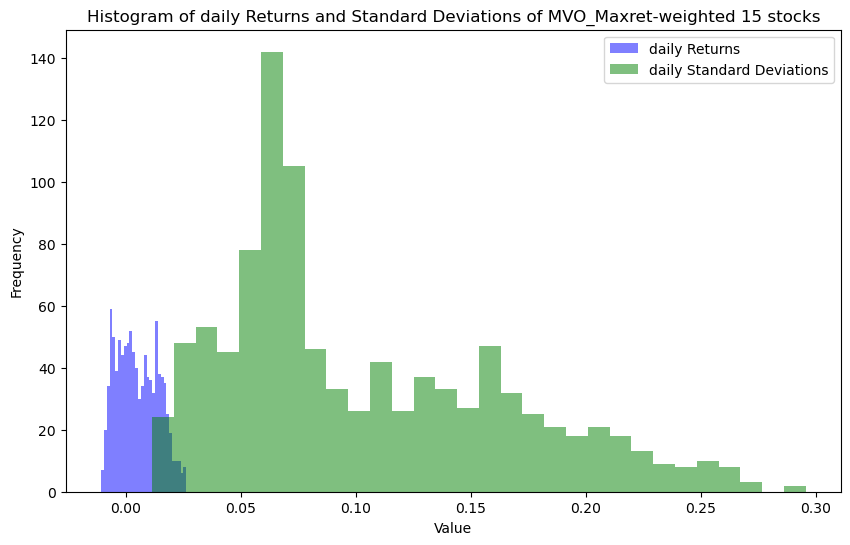

In [34]:
#MVO_Maxret_weighted 15의 주간 수익률과 표준편차 히스토그램

returns_MVO_Maxret_weighted_15, std_devs_MVO_Maxret_weighted_15 = zip(*daily_statistics_MVO_Maxret_weighted_15)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_MVO_Maxret_weighted_15, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_MVO_Maxret_weighted_15, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of MVO_Maxret-weighted 15 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

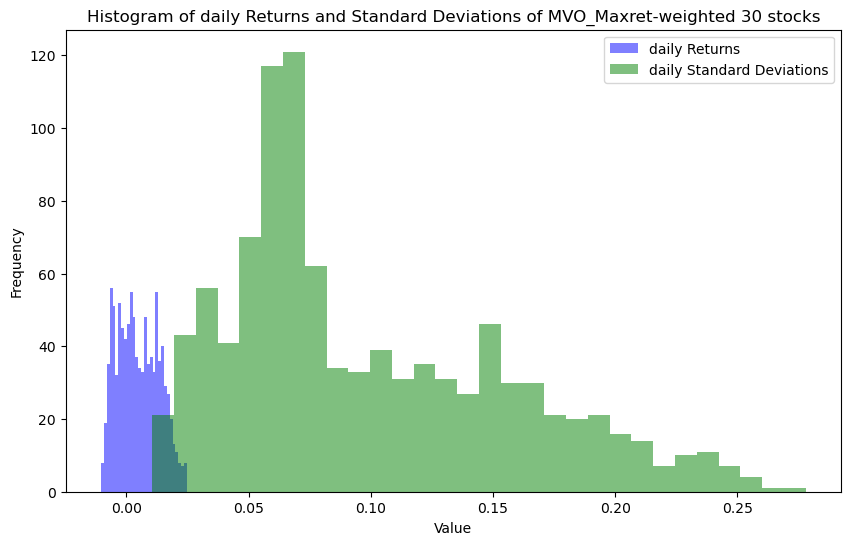

In [35]:
#MVO_Maxret_weighted 30의 주간 수익률과 표준편차 히스토그램

returns_MVO_Maxret_weighted_30, std_devs_MVO_Maxret_weighted_30 = zip(*daily_statistics_MVO_Maxret_weighted_30)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_MVO_Maxret_weighted_30, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_MVO_Maxret_weighted_30, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of MVO_Maxret-weighted 30 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

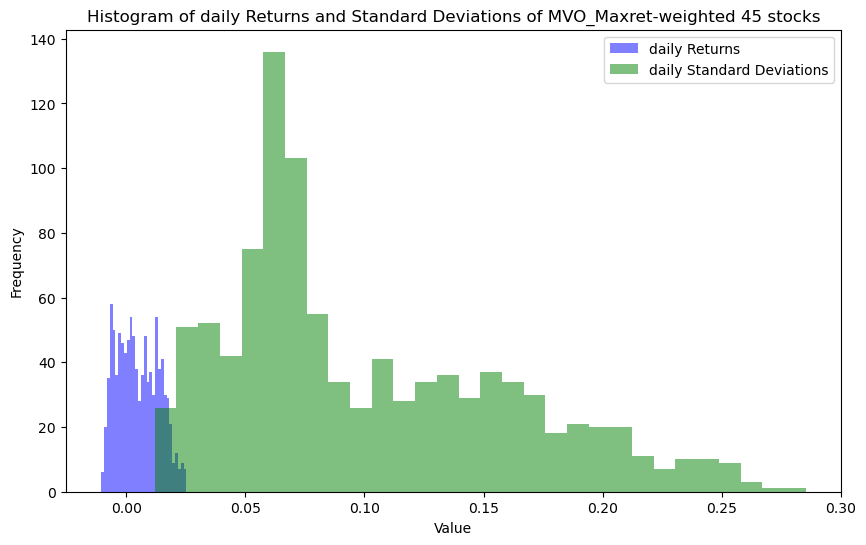

In [36]:
#MVO_Maxret_weighted 45의 주간 수익률과 표준편차 히스토그램

returns_MVO_Maxret_weighted_45, std_devs_MVO_Maxret_weighted_45 = zip(*daily_statistics_MVO_Maxret_weighted_45)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_MVO_Maxret_weighted_45, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_MVO_Maxret_weighted_45, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of MVO_Maxret-weighted 45 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

## Max Sharpe

In [37]:
MVO_MaxSharpe_weighted_15 = {'AAPL': 0.13333, 'AMZN': 0.03333, 'NVDA': 0.06425, 'JPM': 0.03333, 'PG': 0.13333, 'PFE': 0.03333, 'JNJ': 0.03333, 'KO': 0.03973, 'XOM': 0.03333, 'NEE': 0.09602, 'GOOGL': 0.03333, 'MSFT': 0.13333, 'TSLA': 0.13333, 'NKE': 0.03333, 'BAC': 0.03333}

MVO_MaxSharpe_weighted_30 = {'MSFT': 0.06667, 'AMZN': 0.01667, 'NVDA': 0.06667, 'AAPL': 0.06667, 'GOOGL': 0.01667, 'ADBE': 0.01667, 'JNJ': 0.01667, 'PFE': 0.01667, 'MRK': 0.06667, 'ABT': 0.01667, 'PG': 0.06667, 'KO': 0.01667, 'JPM': 0.01667, 'GS': 0.01667, 'CAT': 0.01667, 'CVX': 0.01667, 'XOM': 0.01667, 'BA': 0.01666, 'TSLA': 0.06667, 'NEE': 0.06667, 'NKE': 0.01667, 'VZ': 0.01667, 'CRM': 0.01667, 'UNH': 0.06667, 'WMT': 0.06667, 'QCOM': 0.01667, 'BAC': 0.01667, 'V': 0.01667, 'MCD': 0.06667, 'INTC': 0.01666}

MVO_MaxSharpe_weighted_45 = {'AAPL': 0.04444, 'GOOGL': 0.01111, 'MSFT': 0.04444, 'NVDA': 0.04444, 'AMD': 0.04444, 'ORCL': 0.01773, 'CRM': 0.01111, 'INTC': 0.01111, 'CSCO': 0.01111, 'JPM': 0.01111, 'GS': 0.01111, 'BAC': 0.01111, 'MS': 0.01111, 'AXP': 0.01111, 'C': 0.01111, 'JNJ': 0.01111, 'UNH': 0.03783, 'PFE': 0.01111, 'ABBV': 0.04444, 'TSLA': 0.04444, 'AMGN': 0.01111, 'GILD': 0.01111, 'PG': 0.04444, 'KO': 0.01111, 'NKE': 0.01111, 'PEP': 0.04444, 'COST': 0.04444, 'WMT': 0.04444, 'TGT': 0.04444, 'XOM': 0.01111, 'CVX': 0.01111, 'NEE': 0.04444, 'DUK': 0.01111, 'SO': 0.04444, 'SLB': 0.01111, 'MMM': 0.01111, 'CAT': 0.01111, 'HON': 0.01111, 'GE': 0.01111, 'ADP': 0.01111, 'AMZN': 0.01111, 'META': 0.01111, 'HD': 0.01111, 'VZ': 0.01111, 'MRK': 0.04444}

In [38]:
# 시나리오 분석 수행 각각의 가중치 시리즈만 넣어서 만들면 됨
weights_series_MVO_MaxSharpe_weighted_15 = pd.Series(MVO_MaxSharpe_weighted_15)
daily_statistics_MVO_MaxSharpe_weighted_15 = calculate_daily_statistics(scenarios, weights_series_MVO_MaxSharpe_weighted_15)

weights_series_MVO_MaxSharpe_weighted_30 = pd.Series(MVO_MaxSharpe_weighted_30)
daily_statistics_MVO_MaxSharpe_weighted_30 = calculate_daily_statistics(scenarios, weights_series_MVO_MaxSharpe_weighted_30)

weights_series_MVO_MaxSharpe_weighted_45 = pd.Series(MVO_MaxSharpe_weighted_45)
daily_statistics_MVO_MaxSharpe_weighted_45 = calculate_daily_statistics(scenarios, weights_series_MVO_MaxSharpe_weighted_45)

# 첫 번째 시나리오의 통계를 예시로 표시
daily_statistics_MVO_MaxSharpe_weighted_15[0]

(-0.007405773526816658, 0.06205880347607494)

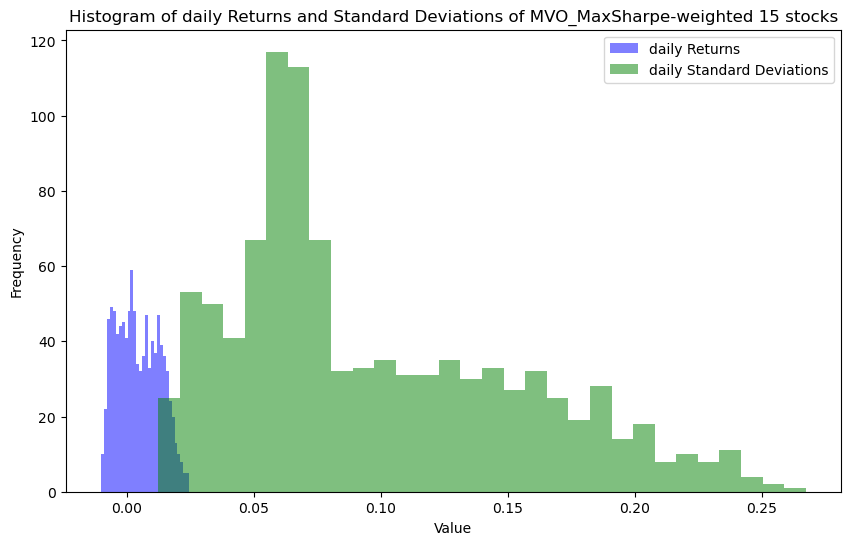

In [39]:
#MVO_MaxSharpe_weighted 15의 주간 수익률과 표준편차 히스토그램

returns_MVO_MaxSharpe_weighted_15, std_devs_MVO_MaxSharpe_weighted_15 = zip(*daily_statistics_MVO_MaxSharpe_weighted_15)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_MVO_MaxSharpe_weighted_15, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_MVO_MaxSharpe_weighted_15, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of MVO_MaxSharpe-weighted 15 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

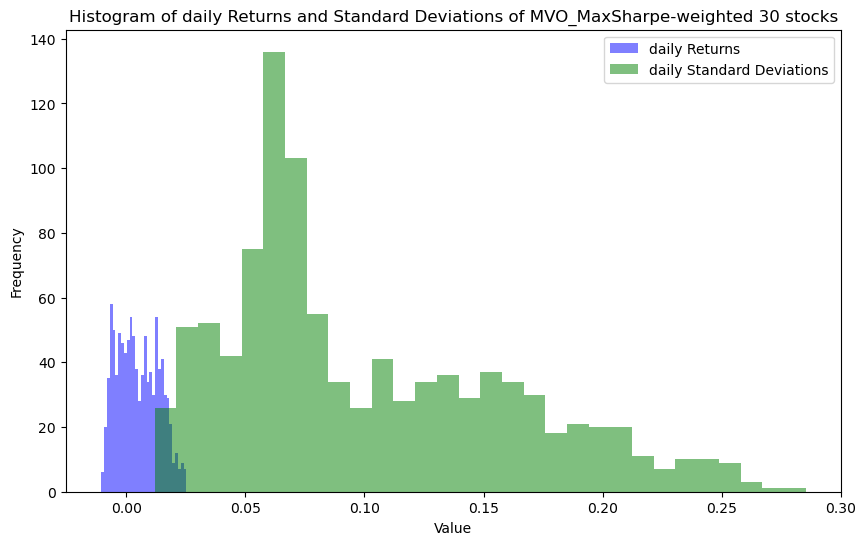

In [40]:
#MVO_MaxSharpe_weighted 30의 주간 수익률과 표준편차 히스토그램

returns_MVO_MaxSharpe_weighted_30, std_devs_MVO_MaxSharpe_weighted_30 = zip(*daily_statistics_MVO_MaxSharpe_weighted_30)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_MVO_MaxSharpe_weighted_30, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_MVO_MaxSharpe_weighted_30, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of MVO_MaxSharpe-weighted 30 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

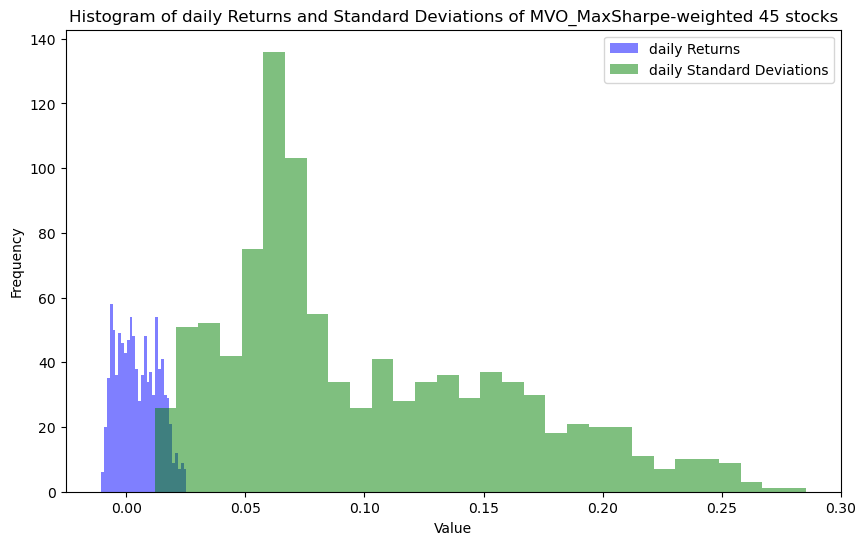

In [41]:
#MVO_MaxSharpe_weighted 45의 주간 수익률과 표준편차 히스토그램

returns_MVO_MaxSharpe_weighted_45, std_devs_MVO_MaxSharpe_weighted_45 = zip(*daily_statistics_MVO_MaxSharpe_weighted_45)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_MVO_MaxSharpe_weighted_45, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_MVO_MaxSharpe_weighted_45, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of MVO_MaxSharpe-weighted 45 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

# **EPO**

## GMV

In [42]:
epo_GMV_weighted_15 = {'AAPL': 0.04575246928786821, 'AMZN': 0.07265377471492239, 'NVDA': 0.06481175209487042, 'JPM': 0.05609762627137712, 'PG': 0.0719435734229653, 'PFE': 0.08771670571734723, 'JNJ': 0.07277777173189208, 'KO': 0.06312539328973277, 'XOM': 0.08609507668538831, 'NEE': 0.07221233969635621, 'GOOGL': 0.05010272070811802, 'MSFT': 0.03828500762569085, 'TSLA': 0.10055629310834088, 'NKE': 0.06129593107749074, 'BAC': 0.05657356456763967}

epo_GMV_weighted_30 = {'MSFT': 0.01666666774419816, 'AMZN': 0.042227409477106695, 'NVDA': 0.03118097512246346, 'AAPL': 0.01666667168358331, 'GOOGL': 0.01809943946174481, 'ADBE': 0.02570202818687248, 'JNJ': 0.035080295142533816, 'PFE': 0.052582684453145526, 'MRK': 0.0475986044981093, 'ABT': 0.022988231711774245, 'PG': 0.03608309079046335, 'KO': 0.027444963001599185, 'JPM': 0.01940313030454212, 'GS': 0.017845787304226788, 'CAT': 0.0336990887241052, 'CVX': 0.03478235727173764, 'XOM': 0.044706637080323186, 'BA': 0.0401698232395637, 'TSLA': 0.06666666228078902, 'NEE': 0.03819709421977127, 'NKE': 0.0283698072324536, 'VZ': 0.05348428364961278, 'CRM': 0.03498396614637049, 'UNH': 0.028482865710042066, 'WMT': 0.05711849959966492, 'QCOM': 0.03681044243477318, 'BAC': 0.020125552595200585, 'V': 0.01666666803231992, 'MCD': 0.02878298920491861, 'INTC': 0.027383283695990274}

epo_GMV_weighted_45 = {'AAPL': 0.011111111751157617, 'GOOGL': 0.01111111297691952, 'MSFT': 0.011111111430617887, 'NVDA': 0.020599077895606076, 'AMD': 0.03653237143698704, 'ORCL': 0.015218203234319534, 'CRM': 0.025585621866165295, 'INTC': 0.0148918676649769, 'CSCO': 0.011111111697909464, 'JPM': 0.011111111820343578, 'GS': 0.011111111721518976, 'BAC': 0.011111111767753831, 'MS': 0.011111111469553583, 'AXP': 0.011111112963466332, 'C': 0.011111112282785603, 'JNJ': 0.01964611725182824, 'UNH': 0.015656892605666366, 'PFE': 0.035078102280757445, 'ABBV': 0.03551029346356419, 'TSLA': 0.044444444168593604, 'AMGN': 0.02325584568021071, 'GILD': 0.04291396596857637, 'PG': 0.0206357790550594, 'KO': 0.013316299685923442, 'NKE': 0.01674069301271715, 'PEP': 0.011111111949044126, 'COST': 0.01826983490242041, 'WMT': 0.04056916285774872, 'TGT': 0.037234796445756904, 'XOM': 0.027932252543989945, 'CVX': 0.01919461191506784, 'NEE': 0.024679849836699883, 'DUK': 0.024462591103417974, 'SO': 0.023809199341675347, 'SLB': 0.04092564530241869, 'MMM': 0.01548505448035055, 'CAT': 0.017262973373497175, 'HON': 0.011111111477449984, 'GE': 0.035796179555666094, 'ADP': 0.011111111372353847, 'AMZN': 0.03089377368024163, 'META': 0.03873632462625635, 'HD': 0.0111111116930388, 'VZ': 0.03677614040679746, 'MRK': 0.03239046798313052}

In [43]:
# 시나리오 분석 수행 각각의 가중치 시리즈만 넣어서 만들면 됨
weights_series_epo_GMV_15 = pd.Series(epo_GMV_weighted_15)
daily_statistics_epo_GMV_15 = calculate_daily_statistics(scenarios, weights_series_epo_GMV_15)

weights_series_epo_GMV_30 = pd.Series(epo_GMV_weighted_30)
daily_statistics_epo_GMV_30 = calculate_daily_statistics(scenarios, weights_series_epo_GMV_30)

weights_series_epo_GMV_45 = pd.Series(epo_GMV_weighted_45)
daily_statistics_epo_GMV_45 = calculate_daily_statistics(scenarios, weights_series_epo_GMV_45)

# 첫 번째 시나리오의 통계를 예시로 표시
daily_statistics_epo_GMV_15[0]

(-0.006442873997314288, 0.05381391288169708)

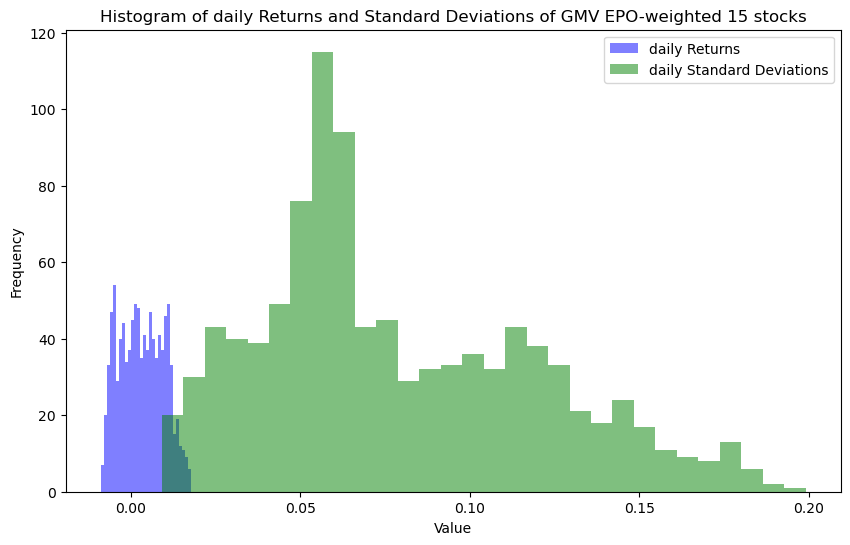

In [44]:
#epo_GMV_weighted_15의 주간 수익률과 표준편차 히스토그램

returns_epo_GMV_15, std_devs_epo_GMV_15 = zip(*daily_statistics_epo_GMV_15)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_epo_GMV_15, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_epo_GMV_15, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of GMV EPO-weighted 15 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

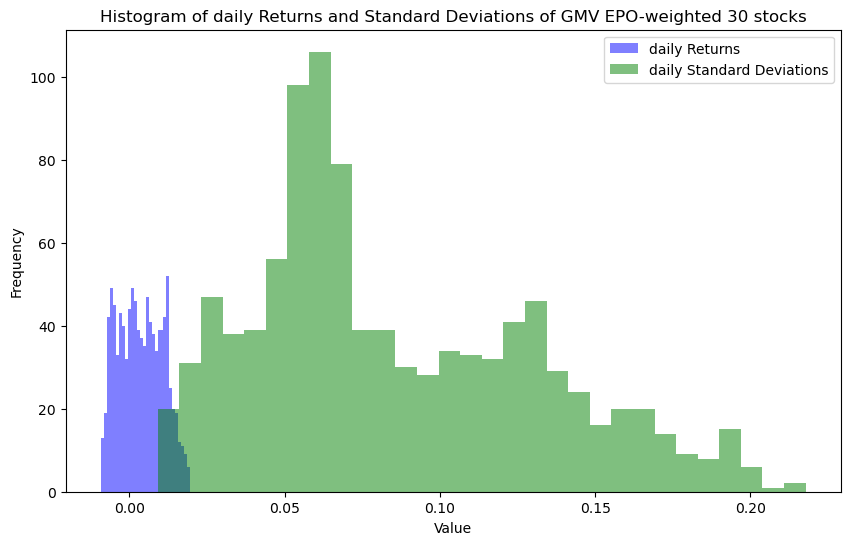

In [45]:
#epo_GMV_weighted_30의 주간 수익률과 표준편차 히스토그램

returns_epo_GMV_30, std_devs_epo_GMV_30 = zip(*daily_statistics_epo_GMV_30)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_epo_GMV_30, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_epo_GMV_30, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of GMV EPO-weighted 30 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

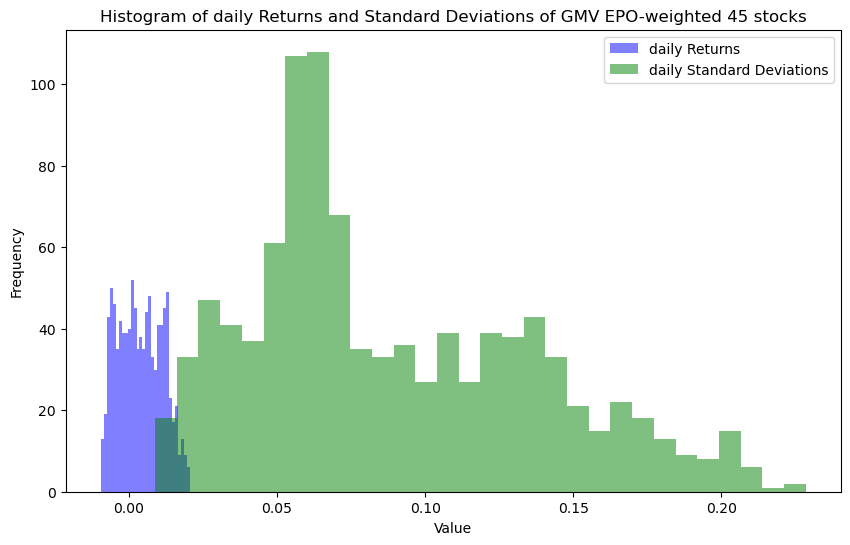

In [46]:
#epo_GMV_weighted_45의 주간 수익률과 표준편차 히스토그램

returns_epo_GMV_45, std_devs_epo_GMV_45 = zip(*daily_statistics_epo_GMV_45)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_epo_GMV_45, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_epo_GMV_45, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of GMV EPO-weighted 45 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

## Max Return

In [47]:
epo_Maxret_weighted_15 = {'AAPL': 0.13333, 'AMZN': 0.03333, 'NVDA': 0.13333, 'JPM': 0.03333, 'PG': 0.13333, 'PFE': 0.03333, 'JNJ': 0.03333, 'KO': 0.03333, 'XOM': 0.03333, 'NEE': 0.03333, 'GOOGL': 0.03333, 'MSFT': 0.13333, 'TSLA': 0.13333, 'NKE': 0.03333, 'BAC': 0.03333}

epo_Maxret_weighted_30 = {'MSFT': 0.06667, 'AMZN': 0.01667, 'NVDA': 0.06667, 'AAPL': 0.06667, 'GOOGL': 0.06667, 'ADBE': 0.01667, 'JNJ': 0.01667, 'PFE': 0.01667, 'MRK': 0.06667, 'ABT': 0.06667, 'PG': 0.06667, 'KO': 0.01667, 'JPM': 0.01667, 'GS': 0.01667, 'CAT': 0.01667, 'CVX': 0.01667, 'XOM': 0.01667, 'BA': 0.06667, 'TSLA': 0.01667, 'NEE': 0.01667, 'NKE': 0.01667, 'VZ': 0.06667, 'CRM': 0.01667, 'UNH': 0.06667, 'WMT': 0.01667, 'QCOM': 0.01667, 'BAC': 0.01667, 'V': 0.01667, 'MCD': 0.01667, 'INTC': 0.01667}

epo_Maxret_weighted_45 = {'AAPL': 0.04444, 'GOOGL': 0.04444, 'MSFT': 0.04444, 'NVDA': 0.04444, 'AMD': 0.04444, 'ORCL': 0.04444, 'CRM': 0.01111, 'INTC': 0.01111, 'CSCO': 0.01111, 'JPM': 0.01111, 'GS': 0.01111, 'BAC': 0.01111, 'MS': 0.01111, 'AXP': 0.01111, 'C': 0.01111, 'JNJ': 0.04444, 'UNH': 0.01111, 'PFE': 0.01111, 'ABBV': 0.04444, 'TSLA': 0.01111, 'AMGN': 0.01111, 'GILD': 0.04444, 'PG': 0.01111, 'KO': 0.031, 'NKE': 0.029, 'PEP': 0.04444, 'COST': 0.037, 'WMT': 0.04444, 'TGT': 0.016, 'XOM': 0.01111, 'CVX': 0.043, 'NEE': 0.01111, 'DUK': 0.01111, 'SO': 0.01111, 'SLB': 0.01111, 'MMM': 0.01111, 'CAT': 0.01111, 'HON': 0.01111, 'GE': 0.01111, 'ADP': 0.01111, 'AMZN': 0.01111, 'META': 0.01111, 'HD': 0.01111, 'VZ': 0.04444, 'MRK': 0.04444}

In [48]:
# 시나리오 분석 수행 각각의 가중치 시리즈만 넣어서 만들면 됨
weights_series_epo_Maxret_15 = pd.Series(epo_Maxret_weighted_15)
daily_statistics_epo_Maxret_15 = calculate_daily_statistics(scenarios, weights_series_epo_Maxret_15)

weights_series_epo_Maxret_30 = pd.Series(epo_Maxret_weighted_30)
daily_statistics_epo_Maxret_30 = calculate_daily_statistics(scenarios, weights_series_epo_Maxret_30)

weights_series_epo_Maxret_45 = pd.Series(epo_Maxret_weighted_45)
daily_statistics_epo_Maxret_45 = calculate_daily_statistics(scenarios, weights_series_epo_Maxret_45)

# 첫 번째 시나리오의 통계를 예시로 표시
daily_statistics_epo_Maxret_15[0]

(-0.007710447628499304, 0.06469593832411079)

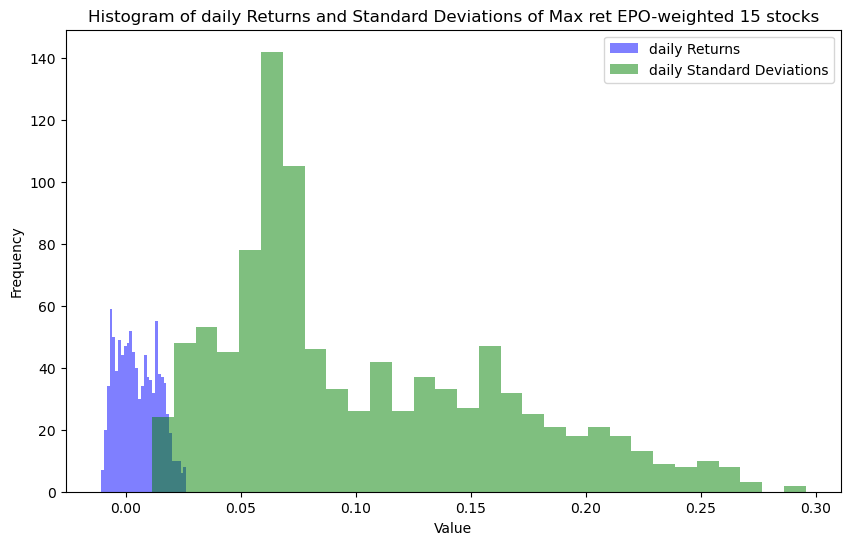

In [49]:
#epo_Maxret_weighted_15의 주간 수익률과 표준편차 히스토그램

returns_epo_Maxret_15, std_devs_epo_Maxret_15 = zip(*daily_statistics_epo_Maxret_15)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_epo_Maxret_15, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_epo_Maxret_15, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of Max ret EPO-weighted 15 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

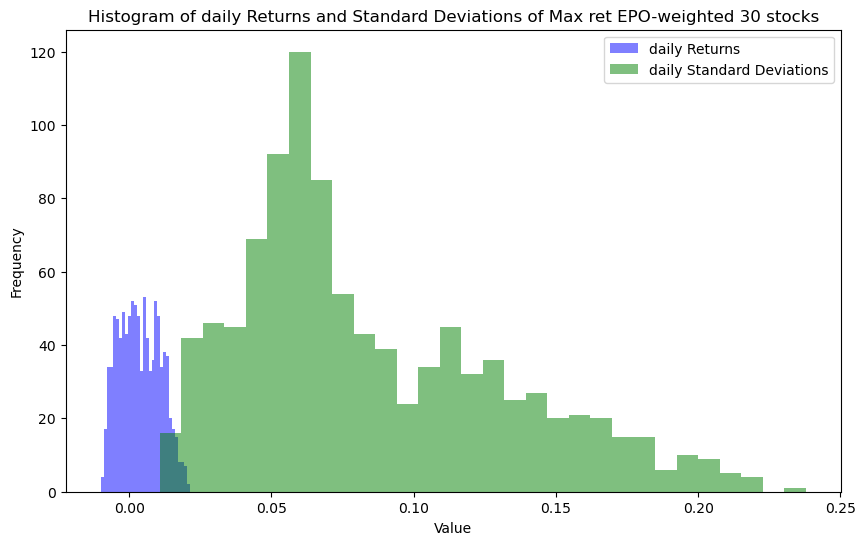

In [50]:
#epo_Maxret_weighted_30의 주간 수익률과 표준편차 히스토그램

returns_epo_Maxret_30, std_devs_epo_Maxret_30 = zip(*daily_statistics_epo_Maxret_30)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_epo_Maxret_30, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_epo_Maxret_30, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of Max ret EPO-weighted 30 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

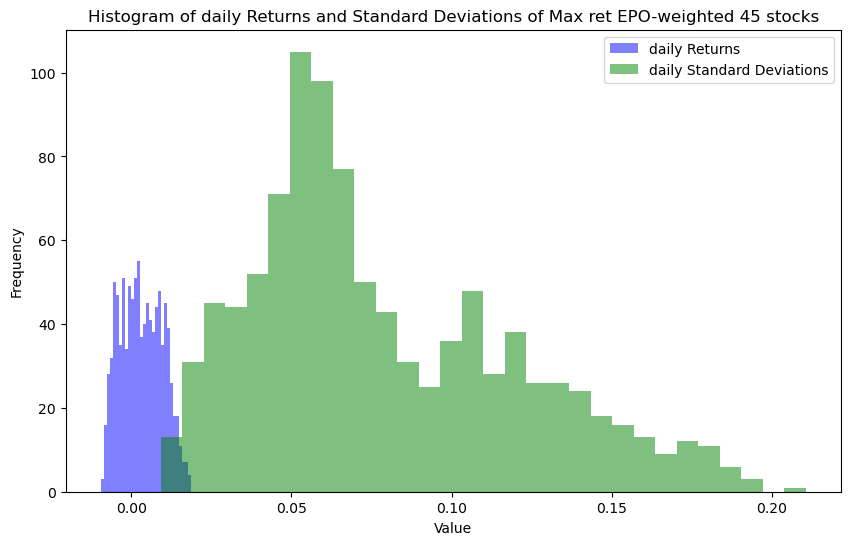

In [51]:
#epo_Maxret_weighted_45의 주간 수익률과 표준편차 히스토그램

returns_epo_Maxret_45, std_devs_epo_Maxret_45 = zip(*daily_statistics_epo_Maxret_45)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_epo_Maxret_45, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_epo_Maxret_45, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of Max ret EPO-weighted 45 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

## Max Sharpe

In [52]:
epo_MaxSharpe_weighted_15 = {'AAPL': 0.13333, 'AMZN': 0.03333, 'NVDA': 0.13333, 'JPM': 0.03333, 'PG': 0.09539, 'PFE': 0.03333, 'JNJ': 0.03333, 'KO': 0.03333, 'XOM': 0.03707, 'NEE': 0.05699, 'GOOGL': 0.03897, 'MSFT': 0.13333, 'TSLA': 0.13333, 'NKE': 0.03825, 'BAC': 0.03333}

epo_MaxSharpe_weighted_30 = {'MSFT': 0.06667, 'AMZN': 0.01667, 'NVDA': 0.06667, 'AAPL': 0.06667, 'GOOGL': 0.0387, 'ADBE': 0.01667, 'JNJ': 0.01667, 'PFE': 0.01667, 'MRK': 0.06667, 'ABT': 0.02469, 'PG': 0.06667, 'KO': 0.01667, 'JPM': 0.01667, 'GS': 0.01667, 'CAT': 0.01667, 'CVX': 0.01667, 'XOM': 0.01667, 'BA': 0.06667, 'TSLA': 0.0443, 'NEE': 0.02974, 'NKE': 0.01667, 'VZ': 0.01667, 'CRM': 0.05967, 'UNH': 0.04331, 'WMT': 0.06667, 'QCOM': 0.01667, 'BAC': 0.01667, 'V': 0.02625, 'MCD': 0.01667, 'INTC': 0.01667}

epo_MaxSharpe_weighted_45 = {'AAPL': 0.04444, 'GOOGL': 0.04379, 'MSFT': 0.04444, 'NVDA': 0.04444, 'AMD': 0.04444, 'ORCL': 0.04444, 'CRM': 0.01111, 'INTC': 0.01111, 'CSCO': 0.01111, 'JPM': 0.01111, 'GS': 0.01111, 'BAC': 0.01111, 'MS': 0.01111, 'AXP': 0.01111, 'C': 0.01111, 'JNJ': 0.04444, 'UNH': 0.01111, 'PFE': 0.01111, 'ABBV': 0.04444, 'TSLA': 0.01111, 'AMGN': 0.01111, 'GILD': 0.04444, 'PG': 0.01111, 'KO': 0.0312, 'NKE': 0.02923, 'PEP': 0.04444, 'COST': 0.03726, 'WMT': 0.04444, 'TGT': 0.01557, 'XOM': 0.01111, 'CVX': 0.04296, 'NEE': 0.01111, 'DUK': 0.01111, 'SO': 0.01111, 'SLB': 0.01111, 'MMM': 0.01111, 'CAT': 0.01111, 'HON': 0.01111, 'GE': 0.01111, 'ADP': 0.01111, 'AMZN': 0.01111, 'META': 0.01111, 'HD': 0.01111, 'VZ': 0.04444, 'MRK': 0.04444}

In [53]:
# 시나리오 분석 수행 각각의 가중치 시리즈만 넣어서 만들면 됨
weights_series_epo_MaxSharpe_15 = pd.Series(epo_MaxSharpe_weighted_15)
daily_statistics_epo_MaxSharpe_15 = calculate_daily_statistics(scenarios, weights_series_epo_MaxSharpe_15)

weights_series_epo_MaxSharpe_30 = pd.Series(epo_MaxSharpe_weighted_30)
daily_statistics_epo_MaxSharpe_30 = calculate_daily_statistics(scenarios, weights_series_epo_MaxSharpe_30)

weights_series_epo_MaxSharpe_45 = pd.Series(epo_MaxSharpe_weighted_45)
daily_statistics_epo_MaxSharpe_45 = calculate_daily_statistics(scenarios, weights_series_epo_MaxSharpe_45)

# 첫 번째 시나리오의 통계를 예시로 표시
daily_statistics_epo_MaxSharpe_15[0]

(-0.007778242875544779, 0.06535355555330936)

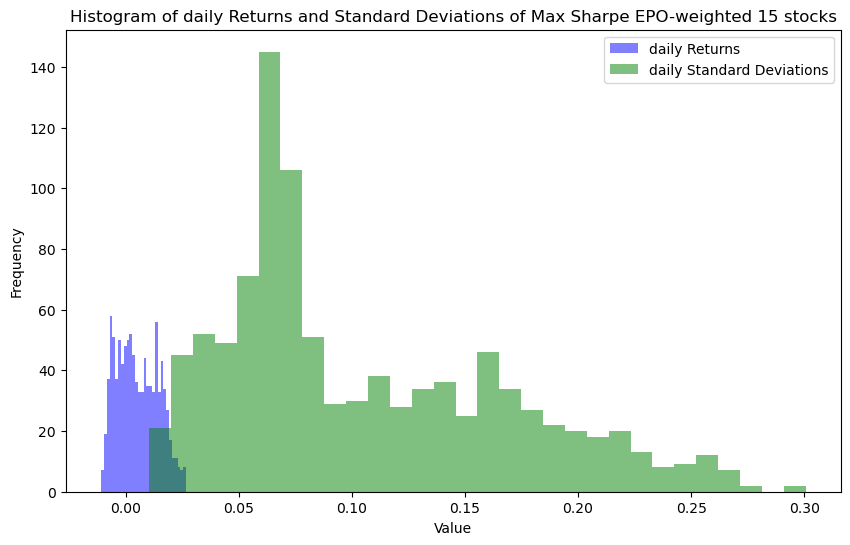

In [54]:
#epo_MaxSharpe_weighted_15의 주간 수익률과 표준편차 히스토그램

returns_epo_MaxSharpe_15, std_devs_epo_MaxSharpe_15 = zip(*daily_statistics_epo_MaxSharpe_15)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_epo_MaxSharpe_15, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_epo_MaxSharpe_15, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of Max Sharpe EPO-weighted 15 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

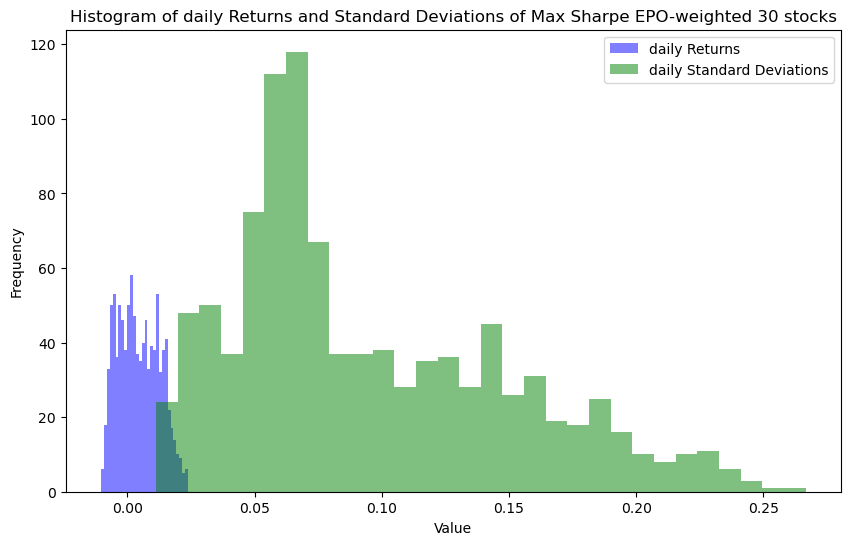

In [55]:
#epo_MaxSharpe_weighted_30의 주간 수익률과 표준편차 히스토그램

returns_epo_MaxSharpe_30, std_devs_epo_MaxSharpe_30 = zip(*daily_statistics_epo_MaxSharpe_30)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_epo_MaxSharpe_30, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_epo_MaxSharpe_30, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of Max Sharpe EPO-weighted 30 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

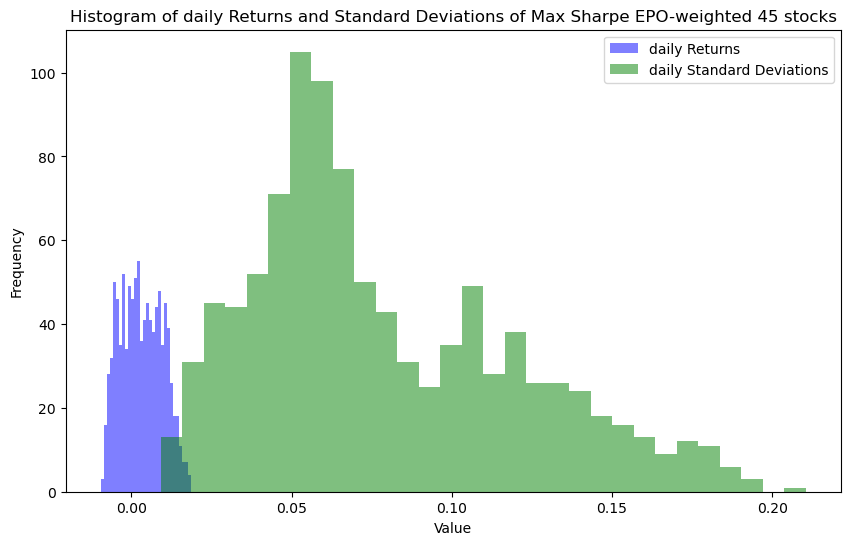

In [56]:
#epo_MaxSharpe_weighted_45의 주간 수익률과 표준편차 히스토그램

returns_epo_MaxSharpe_45, std_devs_epo_MaxSharpe_45 = zip(*daily_statistics_epo_MaxSharpe_45)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_epo_MaxSharpe_45, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_epo_MaxSharpe_45, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of Max Sharpe EPO-weighted 45 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()